In [20]:
"""
predict_xenium_labels.py

Loads:
  - z_ref.npy: embeddings from reference (scRNA-seq)
  - z_spatial.npy: embeddings from spatial Xenium dataset
  - xenium_reference_common_genes_2k.h5ad
  - xenium_spatial_common_genes_2k.h5ad

Trains a classifier on z_ref + reference labels,
Predicts labels for z_spatial,
Evaluates accuracy (since spatial has ground truth),
Saves predictions.
"""

import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt


In [21]:
# --------------------------------------------------------
# 1. Load embeddings + datasets
# --------------------------------------------------------

print("Loading embeddings...")
z_ref = np.load("Results/z_ref.npy")
z_spatial = np.load("Results/z_spatial.npy")

print("Loading matched 2k datasets...")
A = sc.read_h5ad("SmallData/xenium_spatial_common_genes.h5ad")
B = sc.read_h5ad("SmallData/xenium_reference_common_genes.h5ad")


Loading embeddings...
Loading matched 2k datasets...


In [22]:
# --------------------------------------------------------
# 2. # Extract labels
# --------------------------------------------------------

label_col_A = "broad_cell_type"
label_col_B = "celltype_major"

y_ref = B.obs[label_col_B].astype(str).values
y_spatial_true = A.obs[label_col_A].astype(str).values

print("\nReference label distribution:")
print(pd.Series(y_ref).value_counts())

print("\nSpatial true label distribution:")
print(pd.Series(y_spatial_true).value_counts())



Reference label distribution:
T-cells              712
Cancer Epithelial    479
Myeloid              191
CAFs                 137
PVL                  121
Endothelial          118
Normal Epithelial     85
B-cells               79
Plasmablasts          78
Name: count, dtype: int64

Spatial true label distribution:
Cancer Epithelial    752
CAFs                 496
T-cells              177
Myeloid              175
Normal Epithelial    125
Endothelial          124
Unlabeled             89
B-cells               62
Name: count, dtype: int64


In [23]:
# --------------------------------------------------------
# 3. Encode labels → integers
# --------------------------------------------------------

all_labels = np.unique(np.concatenate([y_ref, y_spatial_true]))
label_to_id = {l: i for i, l in enumerate(all_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}

y_ref_id = np.array([label_to_id[l] for l in y_ref])
y_spatial_true_id = np.array([label_to_id[l] for l in y_spatial_true])

In [24]:
# --------------------------------------------------------
# 4. Train classifier on reference embeddings
# --------------------------------------------------------

print("\nTraining classifier on reference latent space...")

# Logistic Regression (strong baseline)
clf = LogisticRegression(max_iter=3000, multi_class="multinomial")
clf.fit(z_ref, y_ref_id)

# Optional: KNN baseline
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(z_ref, y_ref_id)


Training classifier on reference latent space...


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None



=== Training Accuracy (on reference scRNA-seq embeddings) ===
Training Accuracy (LogReg): 0.3535


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (10).

<Figure size 1000x1000 with 0 Axes>

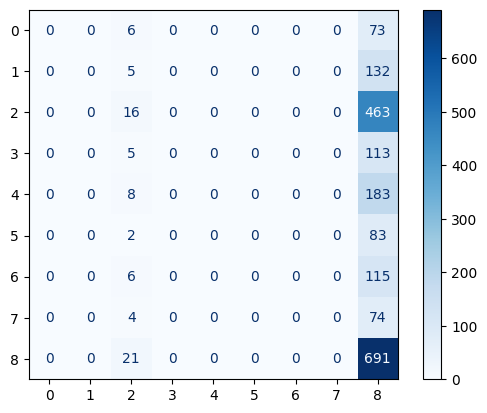

In [25]:
# --------------------------------------------------------
# 4b. Training accuracy on reference embeddings
# --------------------------------------------------------

y_ref_pred_id = clf.predict(z_ref)
y_ref_pred = np.array([id_to_label[i] for i in y_ref_pred_id])

train_acc = accuracy_score(y_ref_id, y_ref_pred_id)
print("\n=== Training Accuracy (on reference scRNA-seq embeddings) ===")
print(f"Training Accuracy (LogReg): {train_acc:.4f}")

# Optional: confusion matrix for training accuracy
cm_train = confusion_matrix(y_ref_id, y_ref_pred_id)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=all_labels)

plt.figure(figsize=(10, 10))
disp_train.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix – Training Accuracy (Reference embeddings)")
plt.tight_layout()
plt.savefig("confusion_matrix_training_reference.png", dpi=200)
plt.show()


In [ ]:
# --------------------------------------------------------
# 5. Predict labels for spatial cells
# --------------------------------------------------------

y_pred_id = clf.predict(z_spatial)
y_pred = np.array([id_to_label[i] for i in y_pred_id])

y_pred_knn_id = knn.predict(z_spatial)
y_pred_knn = np.array([id_to_label[i] for i in y_pred_knn_id])

# --------------------------------------------------------
# 6. Evaluate accuracy
# --------------------------------------------------------

acc_lr = accuracy_score(y_spatial_true_id, y_pred_id)
acc_knn = accuracy_score(y_spatial_true_id, y_pred_knn_id)

print("\n=== Label Transfer Accuracy ===")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"KNN (k=7):            {acc_knn:.4f}")


=== Label Transfer Accuracy ===
Logistic Regression: 0.0915
KNN (k=7):            0.2350


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


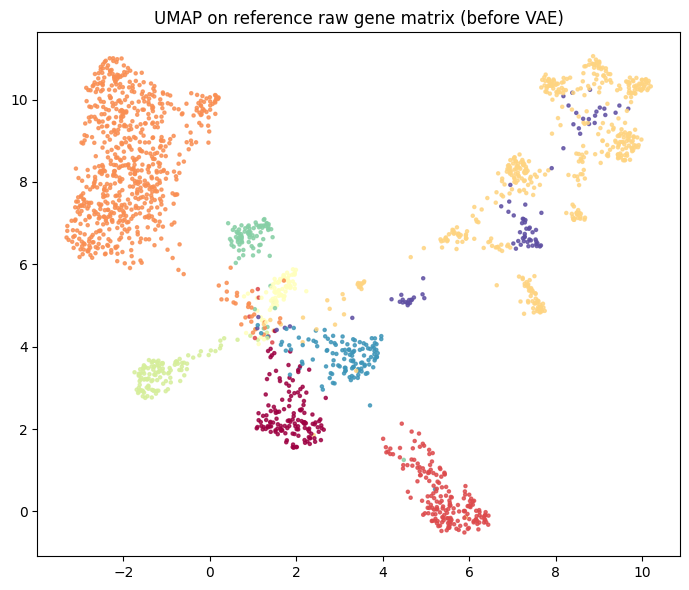

In [26]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import umap

# Load reference data
B = sc.read_h5ad("SmallData/xenium_reference_common_genes.h5ad")
X = np.log1p(B.X.toarray())
y = B.obs[label_col_B].astype(str).values

# UMAP embedding
reducer = umap.UMAP(
    n_components=2,
    metric="euclidean",
    n_neighbors=30,      # can tune (15–50)
    min_dist=0.3,        # can tune (0.1–0.5)
    random_state=42
)

X_umap = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(7, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1],
            c=pd.factorize(y)[0],
            s=5, alpha=0.8, cmap="Spectral")
plt.title("UMAP on reference raw gene matrix (before VAE)")
plt.tight_layout()
plt.show()
